In [1]:
%matplotlib inline
import sys
import os
import os.path
import subprocess
import numpy as np

import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval

In [2]:
from hetdex_api.shot import *

In [3]:
shotlist = {}
__ = """20191203_0000024
20191221_0000022
20191203_0000025
20191222_0000023
20191221_0000023
20191224_0000024
20191222_0000024
20191229_0000023
20191231_0000024
20200101_0000019
20191231_0000025
20200101_0000020"""
shotlist["gama09E"] = __.split()


__ = """20200118_0000017
20200215_0000016
20200119_0000018
20200217_0000014
20200124_0000016
20200217_0000015
20200119_0000019
20200225_0000016
20200125_0000020
20200315_0000012
20200126_0000020"""
shotlist["gama09F"] = __.split()

In [17]:
fileh = tb.open_file('data/gama_recon/20191231_0000024.h5')

In [18]:
fileh.root.Info

/Info (Table(83328,)) 'Fiber Information'
  description := {
  "amp": StringCol(itemsize=2, shape=(), dflt=b'', pos=0),
  "dec": Float32Col(shape=(), dflt=0.0, pos=1),
  "exp": Int32Col(shape=(), dflt=0, pos=2),
  "ifuid": Int32Col(shape=(), dflt=0, pos=3),
  "ifuslot": Int32Col(shape=(), dflt=0, pos=4),
  "ifux": Float32Col(shape=(), dflt=0.0, pos=5),
  "ifuy": Float32Col(shape=(), dflt=0.0, pos=6),
  "ra": Float32Col(shape=(), dflt=0.0, pos=7),
  "specid": Int32Col(shape=(), dflt=0, pos=8)}
  byteorder := 'little'
  chunkshape := (1927,)

In [19]:
fileh.root.CatSpectra

/CatSpectra (Table(380,)) 'Spectral Extraction Information'
  description := {
  "dec": Float32Col(shape=(), dflt=0.0, pos=0),
  "error": Float32Col(shape=(1036,), dflt=0.0, pos=1),
  "ra": Float32Col(shape=(), dflt=0.0, pos=2),
  "spectrum": Float32Col(shape=(1036,), dflt=0.0, pos=3),
  "weight": Float32Col(shape=(1036,), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (21,)

In [20]:
fibers = fileh.root.Fibers
info   = fileh.root.Info

In [21]:
t = Table(fileh.root.Info.read())

In [22]:
uifuslots = np.unique( t["ifuslot"] ).tolist()
print(uifuslots)

[13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 52, 53, 62, 63, 67, 68, 71, 72, 73, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 103, 104, 105, 106]


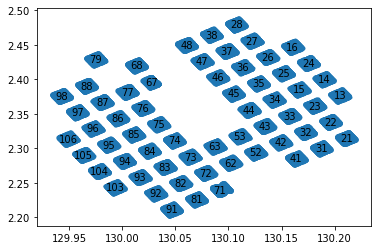

In [24]:
f = plt.figure()
ax = plt.axes()
ax.plot(t["ra"], t["dec"], '.')

for slot in uifuslots:
    jj =  t["ifuslot"] == slot
    ifura, ifudec = np.mean(t["ra"][jj]), np.mean(t["dec"][jj])
    plt.text(ifura, ifudec, slot, ha='center', va='center')

In [25]:
ii = t["ifuslot"] == 77

In [26]:
len(fibers[0][1])

1036

In [27]:
wl = np.arange(len(fibers[0][1]) ) * 2. + 3470.

In [28]:
ifiber = np.arange(len(fibers))

In [32]:
s = []
for i in ifiber[ii]:
    s.append( fibers[i]["spectrum"] )
s = np.array(s)
    

In [33]:
mns = np.nanmean(s, axis=0)

Text(0, 0.5, 'flux [ers/s/cm^2/s/arcsec^2?]')

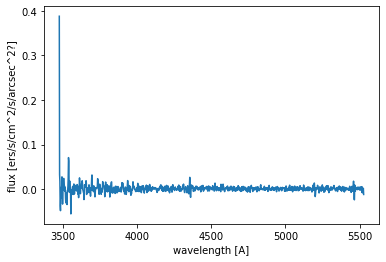

In [34]:
f = plt.figure()
ax = plt.axes()
ax.plot(wl, mns, '-')
plt.xlabel("wavelength [A]")
plt.ylabel("flux [ers/s/cm^2/s/arcsec^2?]")


# Cube stacking code

In [35]:
COMMANDLINE = False

In [36]:
# coding: utf-8
from __future__ import print_function

import pylab
from astropy.io import fits
import sys

from scipy import optimize
import spectrum
import numpy
import optparse
import PolygonIntersect
from matplotlib import pyplot as plt
import spectrum
from astropy.io import ascii
from astropy.table import Table
import os
import glob
import numpy as np

from scipy.interpolate import UnivariateSpline

import sys
from astropy.table import Column, vstack
from astropy.io import ascii

import pickle

from astropy.table import Table
import tables as tb


def circle(x,y,size):
        tt = np.arange(0.,2.*np.pi, np.pi/18.)
        xx = size/2. * np.cos(tt) + x
        yy = size/2. * np.sin(tt) + y
        return xx,yy

def pixel(x,y,size):
    xx,yy=[],[]
    xx.append(x-size/2.)
    yy.append(y-size/2.)

    xx.append(x+size/2.)
    yy.append(y-size/2.)

    xx.append(x+size/2.)
    yy.append(y+size/2.)

    xx.append(x-size/2.)
    yy.append(y+size/2.)

    return xx,yy

def create_3D_header(xc, yc, rad, decd, pixelsize,start,step):
    h = fits.Header()
    #h.update("WCSDIM  ", 3, "");
    #h.update("WAT0_001", "system=image", "");
    h["CTYPE3"] = "Wave"
    h["CRPIX3"] = 1.
    h["CRVAL3"] = start
    h["CDELT3"] = step
    #h["WAT1_001"] = wtype=tan
    h["CTYPE1"] = "RA---TAN"
    h["CRPIX1"] = xc
    h["CRVAL1"] = rad
    h["CDELT1"] = - pixelsize/3600.
    h["CUNIT1"] = "deg"
    #h["WAT2_001"] = wtype=tan
    h["CTYPE2"] = "DEC--TAN"
    h["CRPIX2"] = yc
    h["CRVAL2"] = decd
    h["CDELT2"] = pixelsize/3600.
    h["CUNIT2"] = "deg"
    return h

def create_2D_header(xc, yc, rad, decd, pixelsize):
    h = fits.Header()
    #h.update("WAT1_001", "wtype=tan axtype=ra", "");
    h["CTYPE1"] = "RA--TAN"
    h["CRPIX1"] = xc
    h["CRVAL1"] = "rad"
    h["CDELT1"] = - pixelsize/3600.
    h["CUNIT1"] = "deg"
    #h["WAT2_001"] = wtype=tan
    h["CTYPE2"] = "DEC--TAN"
    h["CRPIX2"] = yc
    h["CRVAL2"] = decd
    h["CDELT2"] = pixelsize/3600.
    h["CUNIT2"] = "deg"
    return h

def create_I_header():
    h = fits.Header()
    #h.update("WAT1_001", "wtype=tan axtype=ra", "");
    h["CTYPE1"] = "pixel"
    h["CRPIX1"] = 1
    h["CRVAL1"] = 1.
    h["CDELT1"] = 1.
    h["CUNIT1"] = "px"
    #h["WAT2_001"] = wtype=tan
    h["CTYPE2"] = "fiber"
    h["CRPIX2"] = 1
    h["CRVAL2"] = 1.
    h["CDELT2"] = 1.
    h["CUNIT2"] = "fib"
    return h

def tan_dir_sci(RA0, DEC0, PA0, RA,DEC, quiet=True):
    """
    Calculates pixel positions in the IFU for a given set of RA and DEC coordinates.

    Input

    IFU_RA0, IFU_DEC0 = IFU zero coordinates (in deg)
    RA, DEC = 1D arrays of RA and DEC coordinates
    astrom_terms = parameters for the astrometric solution
    quiet = Boolean, disable output (standard: False)

    Returns:
    pixx, pixy = two 1D arrays containing x and y coordinates (in deg!) for the given RAs and DECs
    """
    if not quiet: print("IFU_RA0, IFU_DEC0 = {},{}".format( IFU_RA0, IFU_DEC0) )

    rRA0  = RA0*np.pi/180.
    rDEC0  = DEC0*np.pi/180.

    rPA0 = PA0*np.pi/180.

    if not quiet: print("[tan_dir_sci] IFU_RA0, IFU_DEC0 = {},{}".format( IFU_RA0, IFU_DEC0 ) )

    rRA = RA*np.pi/180.

    rDEC = DEC*np.pi/180.

    if not quiet: print("[tan_dir_gui] rRA, rDEC: {}, {}".format( rRA, rDEC ) )

    # eq 9 in Greisen AIPSMEMO27
    L = np.cos(rDEC)*np.sin(rRA - rRA0)/  (np.sin(rDEC)*np.sin(rDEC0) + np.cos(rDEC)*np.cos(rDEC0)*np.cos(rRA - rRA0))

    M = (np.sin(rDEC)*np.cos(rDEC0) - np.cos(rDEC)*np.sin(rDEC0)*np.cos(rRA - rRA0))/(np.sin(rDEC)*        
                                                np.sin(rDEC0) + np.cos(rDEC)*np.cos(rDEC0)*np.cos(rRA - rRA0))

    # eq 5 in Greisen AIPSMEMO27
    pixx = L*np.cos(rPA0) + M*np.sin(rPA0)
    pixy = M*np.cos(rPA0) - L*np.sin(rPA0)

    return - pixx/np.pi*180.*3600., pixy/np.pi*180.*3600.


def findZeroPixRaDec(x,y, RA0, DEC0):
    """
    Find RA and DEC coordinates that correspond to the given
    pixel coordinates.
    We do this here the cheap way. We use a nonlinear fit 
    rather than working out the inverse transformation.
    """
    def peval(p,RA0, DEC0):
        RA,DEC = p
        return tan_dir_sci(RA0, DEC0, 0., RA, DEC, quiet=True)

    def resid(p,x,y,RA0, DEC0):
        xt,yt = peval(p,RA0, DEC0)
        return (xt-x), (yt-y)

    p0 = [RA0,DEC0]
    bestfit = optimize.leastsq(resid, p0, args=(x,y,RA0,DEC0) )
    return bestfit[0]

def hms2deg(hms):
    tt = hms.split(":")
    h,m,s = float(tt[0]), float(tt[1]), float(tt[2])
    return h*15. + m/4. + s/240.

def dms2deg(dms):
    tt = dms.split(":")
    d,m,s = float(tt[0]), float(tt[1]), float(tt[2])
    return d + m/60. + s/3600.


In [3]:
RA0 = None 
DEC0 = None
FIBERD = 1.5
nx = None
ny = None
pixelsize = .5
fiberA = np.pi*(FIBERD/2.)**2.

pa = 0.
ifuslots = ["085", "086", "095", "096"]
ifuslots = ["085", "095"]
ifuslots = ["085", "075"]
ifuslots = ["085"]

basepath = "./data/gama_recon"
shotlist = ["20191231_0000024","20191231_0000025"]

#shotlist = ["20200118_0000017","20200119_0000018"]
#shotlist = ["20191231_0000024","20191231_0000025", "20200118_0000017","20200119_0000018"]

__ = """20191203_0000024
20191221_0000022
20191203_0000025
20191222_0000023
20191221_0000023
20191224_0000024
20191222_0000024
20191229_0000023
20191231_0000024
20200101_0000019
20191231_0000025
20200101_0000020"""
shotlist = __.split()

#ifuslots = ["085"]
#shotlist = ["20191231_0000024"]
#shotlist = ["20191231_0000024","20191231_0000025"]



write_single_cubes = False
    
if COMMANDLINE:
    import argparse

    parser = argparse.ArgumentParser(description='Build a hetdex cube.')
    #parser.add_argument('--basepath', default="/work/03946/hetdex/maverick/red1/reductions")
    parser.add_argument('--basepath', default="../reductions")
    parser.add_argument('--pa', type=float, default=0.,
                                help='Position angle for cube.')

    parser.add_argument('--write_single_cubes', action="store_true",
                                help='Write individual per-shot cubes before median stacking.')

    parser.add_argument('--norm_smoothing', type=float, default=0.005,
                                help='Smoothing for cross IFU and cross exposure fiber to fiber normalisation (default 0.05)')

    parser.add_argument('--ifuslot', type=str, default = "022", nargs='+', metavar='SLOTS',
            help='IFUslot to create cube for, can pass multiple. ')
    
    parser.add_argument('--shotlist', type=str,
                                help='List of actual shots to use.')

    args = parser.parse_args()

    pa=args.pa
    fiberpos = args.dither_use
    ifuslot = args.ifuslot
    basepath = args.basepath
    shotlist = args.shotlist
    write_single_cubes = args.write_single_cubes
    
    
prefix = ""
extensions = ["sky_subtracted", "sky_spectrum", "fiber_to_fiber"]

# read dithall.use
filebase = {}

exposure_times = []

sky_spectra = [] # holds for each fiber spectrum
                 # the corresponing amplifier wide sky (median accorss all fibers after correcting for fiber_to_fiber)
    
# generic remedy virus wavelength grid
wlgrid = np.arange( 1036 ) * 2. + 3470.
wlstart, wlstop = wlgrid[0], wlgrid[-1]
        


fid = -1

## Loading all spectra for all IFUs in all shots that we plan to combine into a cube here

In [4]:
def load_data(shotlist, ifuslots):
    names = ["count", "amplifier", "fiberid", "ra", "dec", "shot", "night", "shotid", "exp"]
    dtype = [int, 'U2', int, float, float, 'U12', 'U8', 'U3', float]
    fibers = Table(names=names, dtype=dtype)

    spectra = {}
    allspec = []

    count = 0
    for shot in shotlist:
        print("Loading shot {}".format(shot))
        hdf5_filename = '{}.h5'.format(shot)
        if not os.path.exists(os.path.join(basepath,hdf5_filename)):
            print("ERROR: File {} does not exist".format(os.path.join(basepath,hdf5_filename)))
            continue
        hdf5file = tb.open_file(os.path.join(basepath,hdf5_filename) )

        h5fibers = hdf5file.root.Fibers
        h5info   = hdf5file.root.Info

        t = Table(h5info.read())

        ifiber = np.arange(len(h5fibers))

        uifus = np.unique( t["ifuslot"] ).tolist()

        for ifu in ifuslots:
            if not int(ifu) in uifus:
                print("WARNING: Shot {} contains no data for IFU slot {}".format(shot, ifu))
                continue
            print("  IFU slot {}".format(ifu))
            # find all spectra that belong to current IFU
            ii = t["ifuslot"] == int(ifu)
            s = []
            for i in ifiber[ii]:
                x,y = t["ra"][i], t["dec"][i]
                allspec.append( h5fibers[i]["spectrum"]  )


                amplifier = ""
                night = shot[:8]
                shotid = shot[9:]
                fibers.add_row([count, amplifier, i, x,y, shot, night, shotid, 0 ])

        print("len(allspec): ", len(allspec))
        print("len(fibers): ", len(fibers))

    allspec = np.array(allspec)
    allspec[np.isnan(allspec)] = 0.
    print("Done.")
    
    return fibers, allspec

fibers, allspec = load_data(shotlist, ifuslots)

Loading shot 20191203_0000024
  IFU slot 085
len(allspec):  1344
len(fibers):  1344
Loading shot 20191221_0000022
  IFU slot 085
len(allspec):  2688
len(fibers):  2688
Loading shot 20191203_0000025
ERROR: File ./data/gama_recon/20191203_0000025.h5 does not exist
Loading shot 20191222_0000023
  IFU slot 085
len(allspec):  4032
len(fibers):  4032
Loading shot 20191221_0000023
  IFU slot 085
len(allspec):  5376
len(fibers):  5376
Loading shot 20191224_0000024
  IFU slot 085
len(allspec):  6720
len(fibers):  6720
Loading shot 20191222_0000024
  IFU slot 085
len(allspec):  8064
len(fibers):  8064
Loading shot 20191229_0000023
  IFU slot 085
len(allspec):  9408
len(fibers):  9408
Loading shot 20191231_0000024
  IFU slot 085
len(allspec):  10752
len(fibers):  10752
Loading shot 20200101_0000019
  IFU slot 085
len(allspec):  12096
len(fibers):  12096
Loading shot 20191231_0000025
  IFU slot 085
len(allspec):  13440
len(fibers):  13440
Loading shot 20200101_0000020
  IFU slot 085
len(allspec): 

## determine a pixel grid

In [5]:
def find_pixel_grid(fibers, RA0=None, DEC0=None, nx = None, ny = None, PLOT = False):
    if RA0 == None or DEC0 == None:
        RA0,DEC0 = numpy.mean(fibers["ra"]), numpy.mean(fibers["dec"])
    print("Set tangent point for projection to RA0 = %.6f and DEC0  = %.6f." % (RA0, DEC0)) 

    fxx,fyy = tan_dir_sci(RA0, DEC0, pa, fibers["ra"], fibers["dec"], quiet=True)


    maxx = max(fxx)+FIBERD/2.
    maxy = max(fyy)+FIBERD/2.
    minx = min(fxx)-FIBERD/2.
    miny = min(fyy)-FIBERD/2.

    print("Extent in RA : {:.1f} \"".format(maxx-minx))
    print("Extent in Dec : {:.1f} \"".format(maxy-miny))

    if nx == None or ny == None:
        # Automatically determine pixel gridsize
        nx = int( round( ( maxx - minx ) / pixelsize ))
        ny = int( round( ( maxy - miny ) / pixelsize ))
        # create list of all pixel center coordinates 
        xx=np.arange(nx)*pixelsize + minx + pixelsize/2.
        yy=np.arange(ny)*pixelsize + miny + pixelsize/2.
    else:
        # use user-defined grid insted
        xx=np.arange(nx)-(nx-1.)/2.
        yy=np.arange(ny)-(ny-1.)/2.
        xx *= pixelsize
        yy *= pixelsize

    X,Y=np.meshgrid(xx,yy)
    pixels = np.zeros( [ len(X.flatten()) ,3]  ) 
    pixels[:,0] = np.arange(len(pixels))
    pixels[:,1] = X.flatten()
    pixels[:,2] = Y.flatten()

    PLOT = False
    if PLOT:
        # plotting
        s = plt.subplot() 
        #for p in pixels:
            #    xx,yy = pixel(p[1],p[2], pixelsize)
        #    s.fill( xx, yy, facecolor='none',linewidth=0.2 )

        for f in zip( fxx,fyy ):
            xx,yy = circle(f[0],f[1], FIBERD)
            s.fill( xx, yy, facecolor='none',linewidth=0.2,edgecolor='blue' )

        s.set_xlabel("x (\")")
        s.set_ylabel("y (\")")
        s.axis('equal')
        
    return pixels,xx,yy,X,Y,fxx,fyy,nx,ny

pixels,xx,yy,X,Y,fxx,fyy,nx,ny = find_pixel_grid(fibers)

Set tangent point for projection to RA0 = 130.010746 and DEC0  = 2.320607.
Extent in RA : 72.7 "
Extent in Dec : 72.1 "


## calculate pixel/fiber intersections

In [6]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()


In [7]:
def calculate_pixel_fiber_intersec(shotlist, fibers, pixelsize, FIBERD, MULTIPROCESSING = True):
    # USING SPARSE MATRICES!!!
    from scipy.sparse import lil_matrix as sparse_matrix
    from scipy.sparse import csr_matrix

    #csr_matrix

    #from numpy import array as sparse_matrix
    import time

    print( "Calculating fiber/pixel weight maps..." )

    nI = {}

    manager = multiprocessing.Manager()
    nI = manager.dict()
    jobs = []


    def worker(shot, shotfibers, pixels, shotfxx, shotfyy, pixelsize, FIBERD, nI):
        I = sparse_matrix( np.zeros([len(pixels),len(shotfibers)], dtype=np.float) ) # I is the pixel fiber intersection matrix
        #I = np.array( np.zeros([len(pixels),len(shotfibers)], dtype=np.float) ) # I is the pixel fiber intersection matrix

        fib_range = numpy.arange( len(shotfibers) )
        pix_range = range( len(pixels) )

        NNN = 0

        start_time = time.time()
        npix = len(pix_range)

        for ip in pix_range:
            if ip % 1000 == 0:



                s = "  {} pixel: {:6d} of {:6d} ".format(shot, ip, npix)
                sys.stdout.write( '\r'* len(s))
                sys.stdout.write(s)
                sys.stdout.flush()

            p = pixels[ip]

            px,py = p[1],p[2]
            #calculate distances of all fibers of this shot to the current pixel
            dd_sq = (shotfxx-px)**2. + (shotfyy-py)**2. 

            # Find which fibers of this shot could possibly intersect with the current pixel
            # in the intersection filter, only shotfibers which overlap the pixel are considered.
            # We only look at shotfibers wich are not further than 
            # sqrt(2) * pixelsize/2 + fiberd/2 
            ii = ( dd_sq < (pixelsize/2. *  1.414 + FIBERD/2.)**2.)
            # create a polygon describing the current pixel
            ppxx,ppyy = pixel(px,py,pixelsize)
            pixel_poly = list( zip(ppxx,ppyy) )

            if any(ii):
                for ifib in fib_range[ii]:
                    fx = shotfxx[ifib]
                    fy = shotfyy[ifib]

                    NNN += 1
                    fpxx,fpyy = circle(fx,fy,FIBERD)
                    fiber_poly = list( zip(fpxx,fpyy) )
                    fiber_array = PolygonIntersect.toPointsArray(fiber_poly)
                    pixel_array = PolygonIntersect.toPointsArray(pixel_poly)
                    # calculate intersection area
                    iA = PolygonIntersect.intersectionArea(fiber_array, pixel_array)
                    # Now, the flux of a given fiber (at a given wavelength)
                    # will be assigned to a pixel weighted by the fraction of the 
                    # total fiber area that is overlapping with the pixel.
                    I[ip,ifib]  = iA#/fiberA


        #nI[shot] =  I.T/fiberA 
        nI[shot] =  csr_matrix( I.T/fiberA ) 

        print("Done.")

        elapsed_time = time.time() - start_time
        print("elapsed_time: {:.2f}".format(elapsed_time) )



    for shot in shotlist:
        print("Launching shot {}".format(shot))

        jj = fibers["shot"] == shot
        shotfibers = fibers[jj]
        shotfxx = fxx[jj]
        shotfyy = fyy[jj]

        if MULTIPROCESSING:
            p = multiprocessing.Process(target=worker, args=(shot, shotfibers, pixels, shotfxx, shotfyy, pixelsize, FIBERD, nI))
            jobs.append(p)
            p.start()
        else:
            worker(shot, shotfibers, pixels, shotfxx, shotfyy, pixelsize, FIBERD, nI)

    if MULTIPROCESSING:
        for proc in jobs:
            proc.join()

    print("All done.")

    return nI

nI = calculate_pixel_fiber_intersec(shotlist, fibers, pixelsize, FIBERD)

Calculating fiber/pixel weight maps...
Launching shot 20191203_0000024
Launching shot 20191221_0000022
Launching shot 20191203_0000025
Launching shot 20191222_0000023
Launching shot 20191221_0000023
  20191203_0000025 pixel:      0 of  20880 Launching shot 20191224_0000024
Launching shot 20191222_0000024
Launching shot 20191229_0000023
Launching shot 20191231_0000024
  20191203_0000025 pixel:   1000 of  20880 Launching shot 20200101_0000019
Launching shot 20191231_0000025
  20191221_0000022 pixel:      0 of  20880 Launching shot 20200101_0000020
  20200101_0000020 pixel:   6000 of  20880 Done.
  20191203_0000024 pixel:   7000 of  20880 elapsed_time: 4.64
  20191224_0000024 pixel:  18000 of  20880 Done.
elapsed_time: 17.86
  20191221_0000023 pixel:  20000 of  20880 Done.
  20191222_0000024 pixel:  20000 of  20880 elapsed_time: 18.39
  20200101_0000019 pixel:  17000 of  20880 Done.
Done.
elapsed_time: 18.24
elapsed_time: 18.32
  20191224_0000024 pixel:  20000 of  20880 Done.
elapsed_time

## Create Cube

In [8]:
def build_cubes(shotlist, fibers, allspec, nI, X,Y,nx, ny, pixelsize, fiberA, wlgrid, wlstart, wlstop):
    print("Creating cube(s)...")
    cube = {}
    W = {}

    for shot in shotlist:
        print("shot {}".format(shot))
        shotspec = allspec[fibers["shot"] == shot]
        ##  shotnormalisations = normalisations[fibers["shot"] == shot]
        # with the help of the intersection matix
        # the pixel values of each wavelength slice are simply the dot product of that matrix (transposed) in the vector
        # of all the fiber values at a give wavelength.
        cube[shot] = np.zeros( [shotspec.shape[1],ny,nx] )

        #W[shot] = np.sum(nI[shot]*fiberA,axis=0)/(pixelsize**2.)
        # this bacame necessary when convarting to sparce matrices
        W[shot] = np.array( np.sum(nI[shot]*fiberA,axis=0)/(pixelsize**2.) )[0]

        # calculate median flux level of all fibers
        kk = (wlgrid > wlstart) * (wlgrid < wlstop) 
        mm = np.median(shotspec[:,kk],axis=1)

        nshotspec = (shotspec.transpose()/mm).transpose()

        IT = nI[shot].transpose()

        def stats(a):
            print("min,max = ", a.min, a.max() )
            print("mean = ", mean(a) )
            print("std = ", std(a) )

        if True:
            for iwl in range(shotspec.shape[1]): # for each wavelength

                if iwl % 100 == 0:
                    s = "WL: %6d %14.6f" % ( iwl,wlgrid[iwl] )
                    sys.stdout.write( '\r'* len(s))
                    sys.stdout.write(s)
                    sys.stdout.flush()

                if True:
                    # usual fast way by matrix multiplication
                    imf2 = IT.dot(shotspec[:,iwl])
                    ii = W[shot] > 0. # prevent zero div error
                    #1/0
                    imf2[ii] = imf2[ii]/W[shot][ii]

                    im2 = imf2.reshape(X.shape)

                    PLOT = False 
                    if PLOT:
                        # PLOT
                        X=0.
                        Y=0.
                        vmin=-20.
                        vmax=20.
                        cmap =  plt.cm.jet 
                        s = plt.subplot(111)
                        dd = np.sqrt((fxx-X)**2. + (fyy-Y)**2.)
                        jj = dd < 50.
                        for ifib,fx,fy in zip(fibers["count"][jj], fxx[jj],fyy[jj]):
                            fpxx,fpyy = circle(fx,fy,FIBERD)
                            #s.plot([fx],[fy],'k.')
                            val = np.nanmedian( shotspec[int(ifib),100:-100] )
                            c = (val-vmin)/(vmax-vmin)

                            s.fill( fpxx,fpyy, facecolor=cmap(c),edgecolor='None',linewidth=1.)
                            #s.text(fx,fy,"{:d}".format(int(ifib) ))
                        plt.show()

                cube[shot][iwl] = im2

            print("")

    # In[156]:


    wstart = wlgrid[0]
    wstep  = wlgrid[1]-wlgrid[0]
    return cube, W, wstart, wstep


cube, W, wstart, wstep = \
    build_cubes(shotlist, fibers, allspec, nI, X,Y,nx, ny, pixelsize, fiberA, wlgrid, wlstart, wlstop)

Creating cube(s)...
shot 20191203_0000024
WL:    400    4270.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20191221_0000022
WL:    300    4070.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20191203_0000025
WL:   1000    5470.000000
shot 20191222_0000023
WL:    200    3870.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20191221_0000023
WL:    200    3870.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20191224_0000024
WL:    200    3870.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20191222_0000024
WL:    200    3870.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20191229_0000023
WL:    200    3870.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20191231_0000024
WL:    300    4070.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20200101_0000019
WL:    200    3870.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20191231_0000025
WL:    300    4070.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000
shot 20200101_0000020
WL:    200    3870.000000

<ipython-input-8-8d984108a669>:23: RuntimeWarning: divide by zero encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()
<ipython-input-8-8d984108a669>:23: RuntimeWarning: invalid value encountered in true_divide
  nshotspec = (shotspec.transpose()/mm).transpose()


WL:   1000    5470.000000


## save output

In [10]:
def save_cube(cube, xx, yy, pixelsize, RA0, DEC0, wstart, wstep, outfilename):
    print("Saving cube to {}.".format(outfilename))
    nI = None
    W = None

    #xc,yc are the cube pixel indices that
    #correspond to RA0 and DEC0 and x = 0" and y = 0"
    xc = -xx[0]/pixelsize + 1 
    yc = -yy[0]/pixelsize + 1 

    h2d = create_2D_header(xc, yc, RA0, DEC0, pixelsize)
    h = create_3D_header(xc, yc, RA0, DEC0, pixelsize,wstart,wstep)

    import numpy as np
    cc = np.array( [cube[shot] for shot in shotlist] )


    cc[cc == 0.] = np.nan

    mc = np.zeros_like(cc[0])

    ymin  = 0

    N = 20
    while ymin < mc.shape[1]:
        xmin  = 0
        while xmin < mc.shape[1]:    
            mc[:,ymin:ymin+N,xmin:xmin+N] = np.nanmedian( cc[:,:,ymin:ymin+N,xmin:xmin+N], axis=0 )
            xmin += N
        ymin += N

    cc[cc == 0.] = np.nan

    cc[np.isnan(cc)] = 0.

    hdu = fits.PrimaryHDU(mc,h)

    hdu.writeto(outfilename,overwrite=True)
    print("Wrote {}.".format(fncube))
    
outfilename = "outcube_{}_{}.fits.gz".format("median","-".join(ifuslots))
save_cube(cube, xx, yy, pixelsize, RA0, DEC0, wstart, wstep, outfilename)

Saving cube to outcube_median_085.fits.gz.
Wrote outcube_median_085.fits.gz.


# show some slice

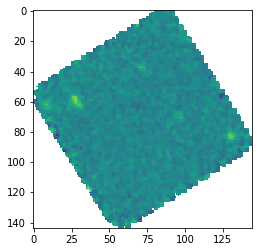

In [11]:
c = spectrum.readSpectrum(outfilename)

from matplotlib import pyplot as plt

plt.imshow(c.data[740])

## Run over multiple IFUs

In [ ]:
uifuslots = [13, 14, 15, 16, 21, 
             22, 23, 24, 25, 26, 
             27, 28, 31, 32, 33, 
             34, 35, 36, 37, 38, 
             41, 42, 43, 44, 45, 
             46, 47, 48, 52, 53, 
             62, 63, 67, 68, 71, 72, 73, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 103, 104, 105, 106]

for ifu in uifuslots[10:12]:
    print("###########################")
    print("Processing ifu {}".format(ifu))
    print("###########################")
    fibers, allspec = load_data(shotlist, [ifu])

    pixels,xx,yy,X,Y,fxx,fyy,nx,ny = find_pixel_grid(fibers)

    nI = calculate_pixel_fiber_intersec(shotlist, fibers, pixelsize, FIBERD)

    # build cubes
    cube, W, wstart, wstep = \
        build_cubes(shotlist, fibers, allspec, nI, X,Y,nx, ny, pixelsize, fiberA, wlgrid, wlstart, wlstop)

    # stack & save
    outfilename = fncube = "outcube_{}_{}.fits.gz".format("median","-".join(ifuslots))
    save_cube(cube, xx, yy, pixelsize, RA0, DEC0, wstart, wstep, outfilename)

###########################
Processing ifu 27
###########################
Loading shot 20191203_0000024
  IFU slot 27
len(allspec):  1344
len(fibers):  1344
Loading shot 20191221_0000022
  IFU slot 27
len(allspec):  2688
len(fibers):  2688
Loading shot 20191203_0000025
ERROR: File ./data/gama_recon/20191203_0000025.h5 does not exist
Loading shot 20191222_0000023
  IFU slot 27
len(allspec):  4032
len(fibers):  4032
Loading shot 20191221_0000023
  IFU slot 27
len(allspec):  5376
len(fibers):  5376
Loading shot 20191224_0000024
  IFU slot 27
len(allspec):  6720
len(fibers):  6720
Loading shot 20191222_0000024
  IFU slot 27
len(allspec):  8064
len(fibers):  8064
Loading shot 20191229_0000023
  IFU slot 27
len(allspec):  9408
len(fibers):  9408
Loading shot 20191231_0000024
  IFU slot 27
len(allspec):  10752
len(fibers):  10752
Loading shot 20200101_0000019
  IFU slot 27
len(allspec):  12096
len(fibers):  12096
Loading shot 20191231_0000025
  IFU slot 27
len(allspec):  13440
len(fibers):  1

## Old Stuff

In [ ]:
# Old way of combining cubes
nI = None

#xc,yc are the cube pixel indices that
#correspond to RA0 and DEC0 and x = 0" and y = 0"
xc = -xx[0]/pixelsize + 1 
yc = -yy[0]/pixelsize + 1 

h2d = create_2D_header(xc, yc, RA0, DEC0, pixelsize)
h = create_3D_header(xc, yc, RA0, DEC0, pixelsize,wstart,wstep)

if False:
    for shot in shotlist:
        if False:
            print("shot {}".format(shot))
            hdu = fits.PrimaryHDU(W[shot].reshape(X.shape),h2d)
            hdu.writeto("pixel_weights_{}_{}.fits.gz".format(shot,"-".join(ifuslots)),overwrite=True)

        if False:
            h = create_I_header()
            hdu = fits.PrimaryHDU(nI,h)
            hdu.writeto("fiber_weights_{}.fits.gz".format("-".join(ifuslots)),overwrite=True)

        if write_single_cubes:
            #if options.normexptime:
            #    h.add_history("Cube data has been normalized by its exposure time.")
            hdu = fits.PrimaryHDU(cube[shot],h)
            hdu.writeto("outcube_{}_{}.fits.gz".format(shot, "-".join(ifuslots)),overwrite=True)


cc = np.array([cube[shot] for shot in shotlist] )
mc = np.median(cc, axis=0)

hdu = fits.PrimaryHDU(mc,h)
fncube = "outcube_{}_{}.fits".format("median","-".join(ifuslots))
hdu.writeto(fncube,overwrite=True)
print("Wrote {}.".format(fncube))

In [ ]:
# old code to compute calculate pixel/fiber intersections

if False:
    
    print( "Calculating fiber/pixel weight maps..." )

    nI = {}

    for shot in shotlist:
        print("shot {}".format(shot))

        jj = fibers["shot"] == shot
        shotfibers = fibers[jj]
        shotfxx = fxx[jj]
        shotfyy = fyy[jj]

        I = numpy.zeros([len(shotfibers),len(pixels)], dtype=float) # I is the pixel fiber intersection matrix

        fib_range = numpy.arange( len(shotfibers) )
        pix_range = range( len(pixels) )

        NNN = 0

        for ip in pix_range:
            p = pixels[ip]

            px,py = p[1],p[2]
            #calculate distances of all fibers of this shot to the current pixel
            dd_sq = (shotfxx-px)**2. + (shotfyy-py)**2. 

            # Find which fibers of this shot could possibly intersect with the current pixel
            # in the intersection filter, only shotfibers which overlap the pixel are considered.
            # We only look at shotfibers wich are not further than 
            # sqrt(2) * pixelsize/2 + fiberd/2 
            ii = ( dd_sq < (pixelsize/2. *  1.414 + FIBERD/2.)**2.)
            # create a polygon describing the current pixel
            ppxx,ppyy = pixel(px,py,pixelsize)
            pixel_poly = list( zip(ppxx,ppyy) )

            if any(ii):
                for ifib in fib_range[ii]:
                    fx = shotfxx[ifib]
                    fy = shotfyy[ifib]

                    NNN += 1
                    fpxx,fpyy = circle(fx,fy,FIBERD)
                    fiber_poly = list( zip(fpxx,fpyy) )
                    fiber_array = PolygonIntersect.toPointsArray(fiber_poly)
                    pixel_array = PolygonIntersect.toPointsArray(pixel_poly)
                    # calculate intersection area
                    iA = PolygonIntersect.intersectionArea(fiber_array, pixel_array)
                    # Now, the flux of a given fiber (at a given wavelength)
                    # will be assigned to a pixel weighted by the fraction of the 
                    # total fiber area that is overlapping with the pixel.
                    I[ifib,ip]  = iA#/fiberA


        plot_count = 0.
        for ip in pix_range:
            PLOT = False
            if PLOT:
                print("pixel ", ip)
                s = pylab.axes()
                p = pixels[ip]
                px,py = p[1],p[2]
                s.plot([px],[py],'s')
                ppxx,ppyy = pixel(px,py,pixelsize)
                pixel_poly = zip(ppxx,ppyy)
                s.fill( ppxx,ppyy, facecolor='none',edgecolor='k',linewidth=0.2 )

                px,py = p[1],p[2]
                #calculate distances of all shotfibers to the current pixel
                dd_sq = (shotfxx-px)**2. + (shotfyy-py)**2.

                #find which shotfibers could possibly intersect with the current pixel
                # in the intersection filter, only shotfibers which overlap the pixel are considered.
                # We only look at shotfibers wich are not further than 
                # sqrt(2) * pixelsize/2 + fiberd/2 
                ii = ( dd_sq < (pixelsize/2. *  1.414 + FIBERD/2.)**2. * 3.)

                for ifib in fib_range[ii]:
                    #if I[ifib,ip] > 0.:
                        fx = shotfxx[ifib]
                        fy = shotfyy[ifib]

                        fpxx,fpyy = circle(fx,fy,FIBERD)

                        s.plot([fx],[fy],'b.')
                        s.fill( fpxx,fpyy, facecolor='k',edgecolor='b',linewidth=0.2 , alpha=I[ifib,ip]+.2 )
                        s.text(fx,fy,'%.2f' % I[ifib,ip])

                plt.axis("equal")
                #s.text(px,py,'%.2f' % W[i])
                pylab.show()
        print("Done.")

        nI[shot] = I/fiberA

    wlstart, wlstop = wlgrid[0], wlgrid[-1]
